In [433]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [434]:
df21 = pd.read_excel("Data_2021_BIOL3319.xlsx", sheet_name=0, skiprows=2)
df19 = pd.read_excel("Data_2019_BIOL3319.xlsx", sheet_name=0, skiprows=2)
df18 = pd.read_excel("Data_2018_BIOL3319.xlsx", sheet_name=0, skiprows=2)
pd.set_option('display.width', 10)

In [435]:
all_dfs = [df18,df19,df21]
for i, df in enumerate(all_dfs):
    df.rename({
        'Distance from edge (in m)': 'distance',
        'LeafLitterDepth (cm)': 'leaf litter depth',
        'Temperature (ºC)': 'temperature',
        'Beetles': 'beetles abundance',
        'Beetles.1': 'beetles richness'
              }, axis=1, inplace=True)
    leaf_idx = df.columns.get_loc('leaf litter depth')
    T_idx = df.columns.get_loc('temperature')
    df['leaf litter depth']=df.iloc[:, leaf_idx:leaf_idx+5].mean(axis=1)
    df['temperature']=df.iloc[:, T_idx:T_idx+5].mean(axis=1)
    df = df[[
        'Date',
        'Transect', 
        'Station',
        'distance',
        'leaf litter depth',
        'temperature',
        'beetles abundance',
        'beetles richness'
            ]]
    all_dfs[i]=df

In [436]:
df21_2 = pd.read_excel("Data_2021_BIOL3319.xlsx", sheet_name=1, skiprows=1)
df19_2 = pd.read_excel("Data_2019_BIOL3319.xlsx", sheet_name=1, skiprows=1)
df18_2 = pd.read_excel("Data_2018_BIOL3319.xlsx", sheet_name=1, skiprows=1)

In [437]:
all_dfs_2 = [df18_2,df19_2,df21_2]
for i, df in enumerate(all_dfs_2):
    T1 = df[df.columns[[0,1]]]
    T2 = df[df.columns[[2,3]]]
    T3 = df[df.columns[[4,5]]]
    T4 = df[df.columns[[6,7]]]
    T5 = df[df.columns[[8,9]]]
    T2.rename({
        'Distance (in m).1': 'Distance (in m)',
        'DBH (in cm).1':'DBH (in cm)',
              }, axis=1, inplace=True)
    T3.rename({
        'Distance (in m).2': 'Distance (in m)',
        'DBH (in cm).2':'DBH (in cm)',
              }, axis=1, inplace=True)
    T4.rename({
        'Distance (in m).3': 'Distance (in m)',
        'DBH (in cm).3':'DBH (in cm)',
              }, axis=1, inplace=True)
    T5.rename({
        'Distance (in m).4': 'Distance (in m)',
        'DBH (in cm).4':'DBH (in cm)',
              }, axis=1, inplace=True)
    
    T1['Transect'] = 1
    T2['Transect'] = 2
    T3['Transect'] = 3
    T4['Transect'] = 4
    T5['Transect'] = 5

    frames = [T1, T2, T3, T4, T5]
    df = pd.concat(frames)
    df = df.dropna()
    df = df.reset_index()
#     print(df.isnull().values.any())
#     print(df['Distance (in m)'].str.any())
#     print(df['Distance (in m)'])
    df = df.astype('float64')
    array = np.array(pd.qcut(df['Distance (in m)'], q=5).value_counts(sort=False))
    frequencies = [np.repeat(i, i) for i in array]
    frequencies = [i for n in frequencies for i in n]
    
    df["bins"] = pd.qcut(df['Distance (in m)'], q=5)
    
    labels = [0,10,30,50,80]
    df["distance"] = pd.qcut(df['Distance (in m)'], q=5, labels=labels)
    
    array = np.array(df[['Transect','distance']].value_counts(sort=False))
    frequencies = [np.repeat(i, i) for i in array]
    frequencies = [i for n in frequencies for i in n]
    
    s = pd.IntervalIndex(pd.qcut(df['Distance (in m)'], q=5))
    
    df["length"]  = s.right-s.left
    df["frequencies"] = frequencies
    df["density"] = df["frequencies"]/df["length"]
    
    L0 = df[df['distance'] == 0]
    L1 = df[df['distance'] == 10]
    L3 = df[df['distance'] == 30]
    L5 = df[df['distance'] == 50]
    L8 = df[df['distance'] == 80]
    
    df = df.groupby(['Transect','distance'],as_index=False).mean()
    df = df.drop(['index','Distance (in m)','length','frequencies'], axis=1)
    df.sort_values(by=['distance','Transect'], inplace=True, ignore_index=True)
#     df = df.loc[df.index.repeat(2)].reset_index(drop=True)
    
    df['Transect'] = df['Transect'].astype(int)
    df = df.rename(columns={'DBH (in cm)': 'DBH','density':'tree density'})
    all_dfs_2[i]=df

In [438]:
for i, df in enumerate(all_dfs):
    df.sort_values(by=['distance','Transect'], inplace=True, ignore_index=True)
#     df["DBH"] = all_dfs_2[i]['DBH (in cm)']
#     df["tree density"] = all_dfs_2[i]['density']
    df=pd.merge(df, all_dfs_2[i], how='left', on=['distance','Transect'])
    all_dfs[i]=df

In [439]:
for df in all_dfs:
    print(df.loc[0,df.eq(0).any()])

distance              0
beetles abundance    12
beetles richness      8
Name: 0, dtype: object
distance               0
beetles abundance     10
beetles richness     3.0
Name: 0, dtype: object
distance              0
beetles abundance    28
beetles richness      5
Name: 0, dtype: object


In [440]:
from scipy.stats import shapiro
import seaborn as sns
import statsmodels.api as sm

for df in all_dfs:
    for var in ['beetles abundance','beetles richness', 'leaf litter depth','temperature','DBH','tree density']:
        test = shapiro(df[var])[1] > 0.05
        print(f'{var} -> {test}')

beetles abundance -> False
beetles richness -> False
leaf litter depth -> False
temperature -> True
DBH -> False
tree density -> False
beetles abundance -> False
beetles richness -> True
leaf litter depth -> True
temperature -> True
DBH -> True
tree density -> True
beetles abundance -> False
beetles richness -> False
leaf litter depth -> False
temperature -> True
DBH -> False
tree density -> False


In [441]:
for i, df in enumerate(all_dfs):
    for var in ['beetles abundance','beetles richness']:
#         sample_transformed, lambd = stats.boxcox(df[var]+1)
        sample_transformed = np.log(df[var]+1)
#         sample_transformed = np.sqrt(df[var])
        df[var] = sample_transformed
        print(f'{var} ->{shapiro(sample_transformed)[1] > 0.05}')
    for var in [ 'leaf litter depth','temperature','DBH','tree density']:
#         sample_transformed, lambd = stats.boxcox(df[var])
#         sample_transformed = np.log(df[var])
        sample_transformed = np.sqrt(df[var])
        df[var] = sample_transformed
        print(f'{var} ->{(sample_transformed)[1] > 0.05}')
        all_dfs[i]=df

beetles abundance ->False
beetles richness ->False
leaf litter depth ->True
temperature ->True
DBH ->True
tree density ->True
beetles abundance ->True
beetles richness ->True
leaf litter depth ->True
temperature ->True
DBH ->False
tree density ->False
beetles abundance ->True
beetles richness ->False
leaf litter depth ->True
temperature ->True
DBH ->True
tree density ->True


In [442]:
from sklearn import linear_model
import matplotlib.pyplot as plt

2018: beetles abundance versus leaf litter depth
Intercept: 
 2.1627480860126824
Coefficients: 
 [-0.5854282]
                            OLS Regression Results                            
Dep. Variable:      beetles abundance   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     3.502
Date:                Fri, 29 Apr 2022   Prob (F-statistic):             0.0674
Time:                        13:55:27   Log-Likelihood:                -71.395
No. Observations:                  50   AIC:                             146.8
Df Residuals:                      48   BIC:                             150.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

2018: beetles richness versus DBH
Intercept: 
 0.3282771624338695
Coefficients: 
 [0.10302714]
                            OLS Regression Results                            
Dep. Variable:       beetles richness   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.164
Date:                Fri, 29 Apr 2022   Prob (F-statistic):              0.148
Time:                        13:55:28   Log-Likelihood:                -55.254
No. Observations:                  50   AIC:                             114.5
Df Residuals:                      48   BIC:                             118.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

/var/folders/z0/r6zbkl914dl0h6jv5ktxb95h0000gn/T/ipykernel_94294/2303797410.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6,2.5))


                            OLS Regression Results                            
Dep. Variable:       beetles richness   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7736
Date:                Fri, 29 Apr 2022   Prob (F-statistic):              0.383
Time:                        13:55:28   Log-Likelihood:                -55.957
No. Observations:                  50   AIC:                             115.9
Df Residuals:                      48   BIC:                             119.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3186      0.364      3.623      0.0

2019: beetles abundance versus DBH
Intercept: 
 -0.7992959799656278
Coefficients: 
 [0.33766792]
                            OLS Regression Results                            
Dep. Variable:      beetles abundance   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     3.800
Date:                Fri, 29 Apr 2022   Prob (F-statistic):             0.0613
Time:                        13:55:29   Log-Likelihood:                -40.839
No. Observations:                  30   AIC:                             85.68
Df Residuals:                      28   BIC:                             88.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

2021: beetles richness versus leaf litter depth
Intercept: 
 1.3222639759733887
Coefficients: 
 [-0.20110048]
                            OLS Regression Results                            
Dep. Variable:       beetles richness   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.462
Date:                Fri, 29 Apr 2022   Prob (F-statistic):              0.123
Time:                        13:55:29   Log-Likelihood:                -37.049
No. Observations:                  50   AIC:                             78.10
Df Residuals:                      48   BIC:                             81.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
2021: beetles abundance versus tree density
Intercept: 
 1.0666012241397396
Coefficients: 
 [0.31339271]
                            OLS Regression Results                            
Dep. Variable:      beetles abundance   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.4374
Date:                Fri, 29 Apr 2022   Prob (F-statistic):              0.512
Time:                        13:55:30   Log-Likelihood:                -58.892
No. Observations:                  50   AIC:                             121.8
Df Residuals:                      48   BIC:                             125.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
             

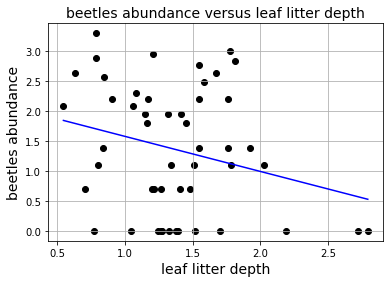

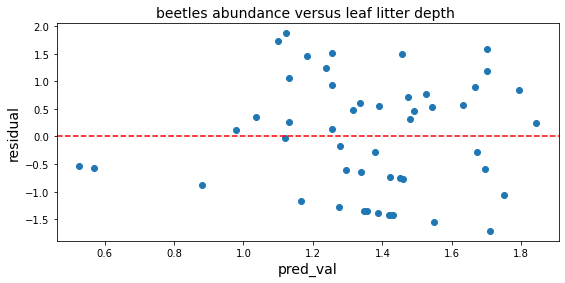

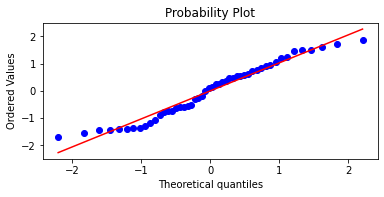

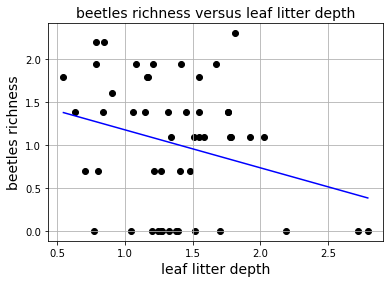

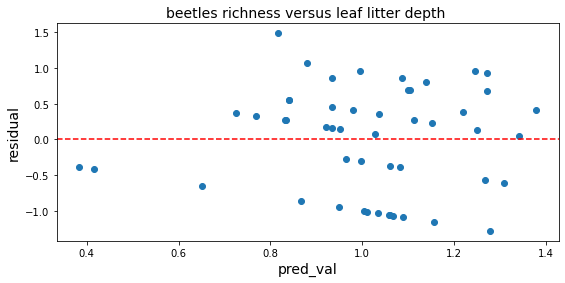

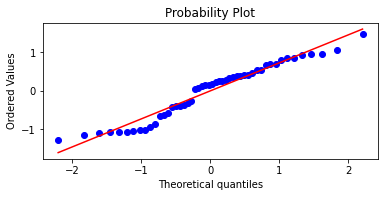

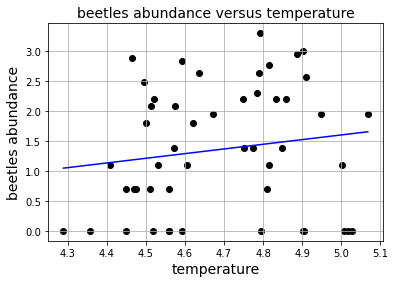

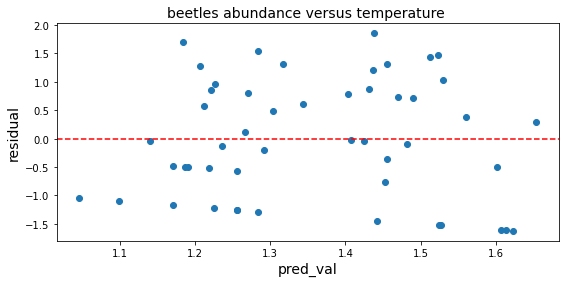

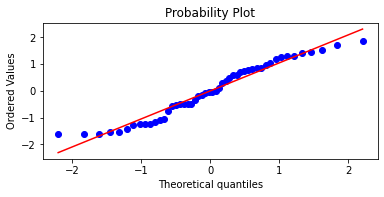

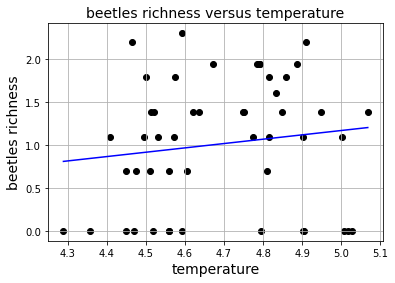

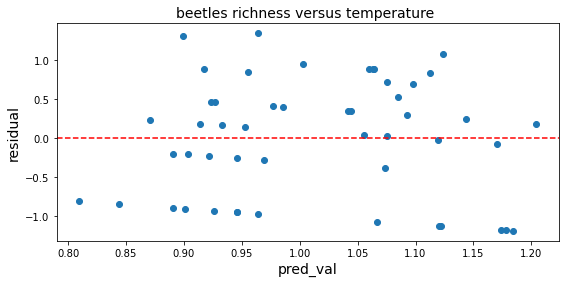

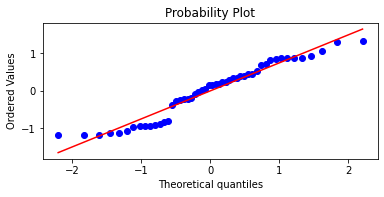

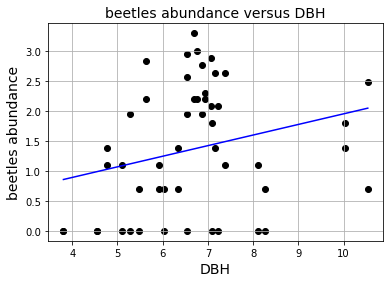

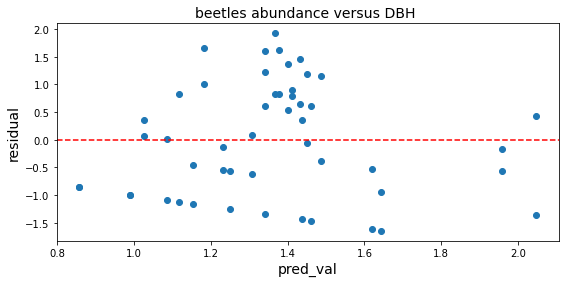

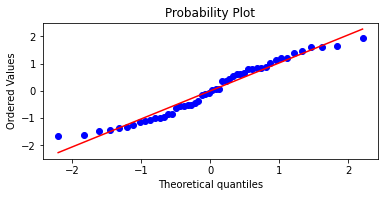

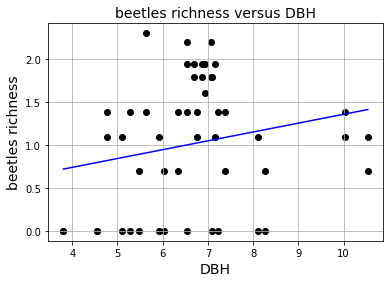

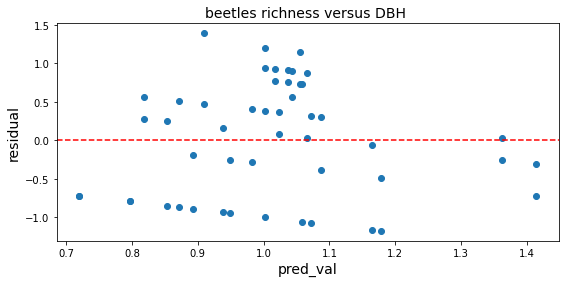

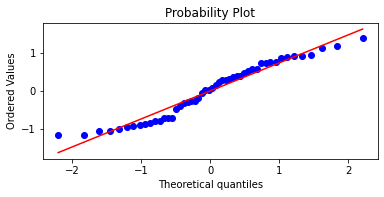

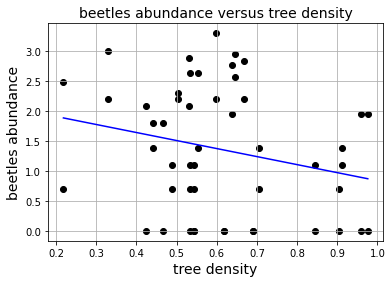

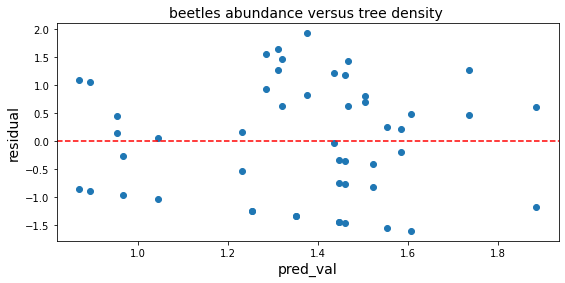

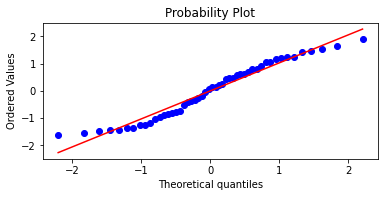

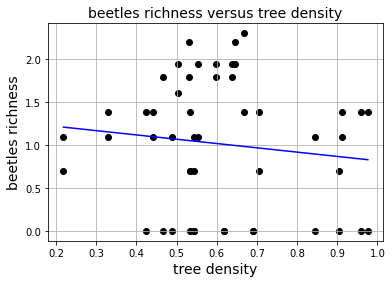

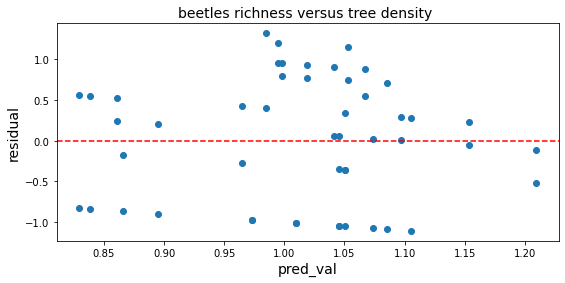

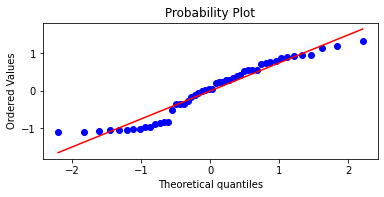

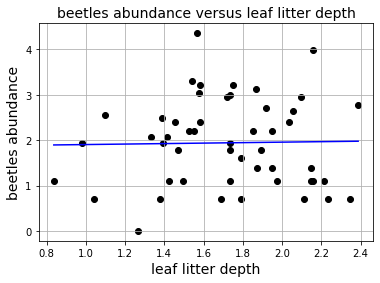

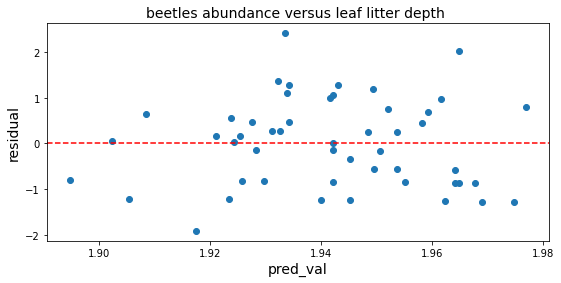

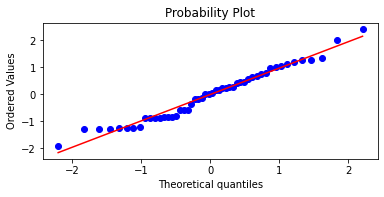

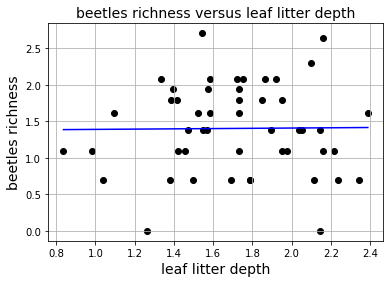

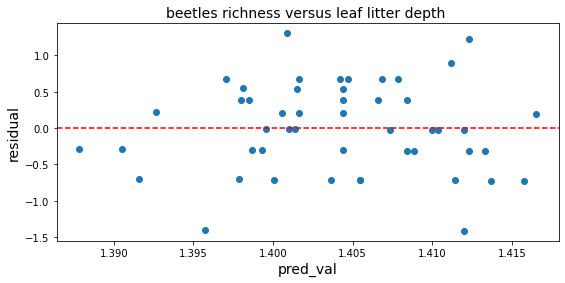

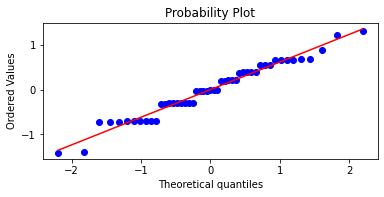

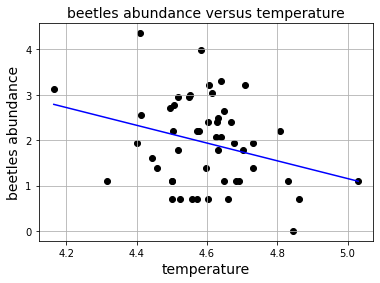

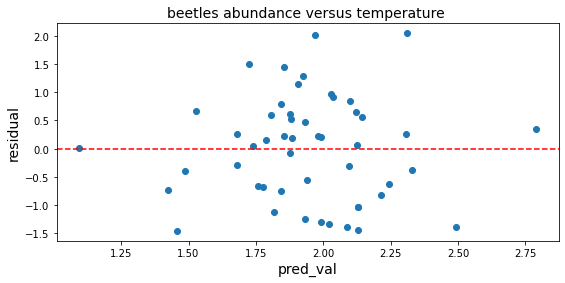

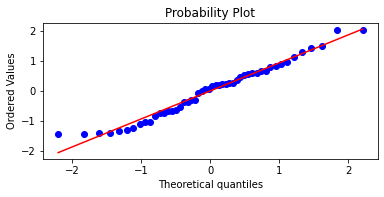

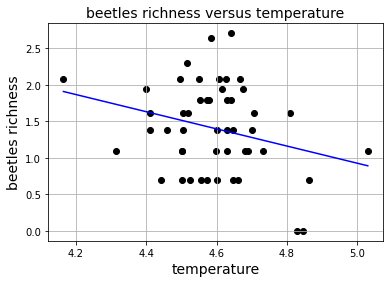

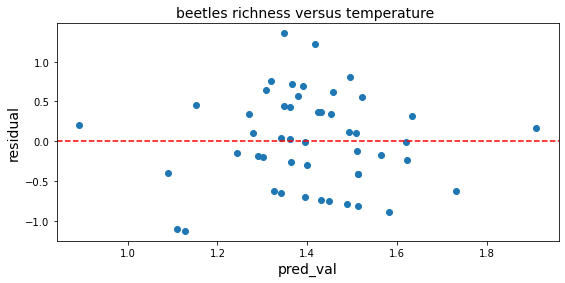

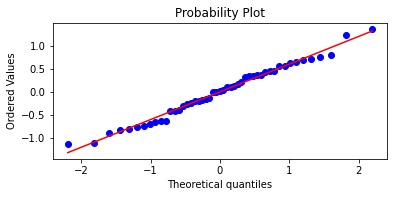

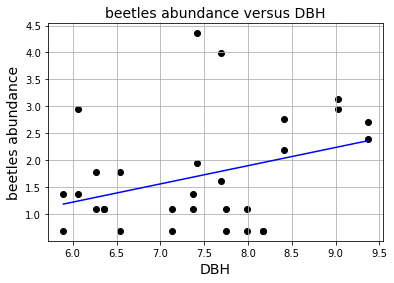

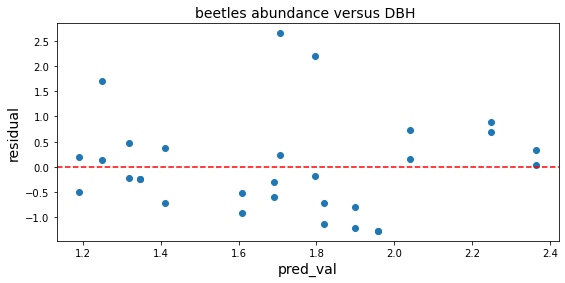

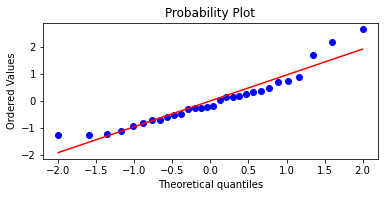

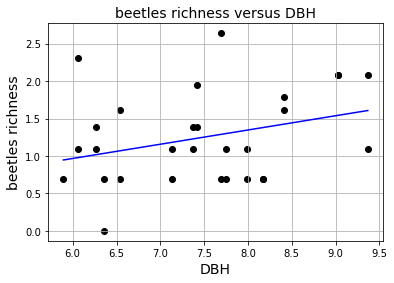

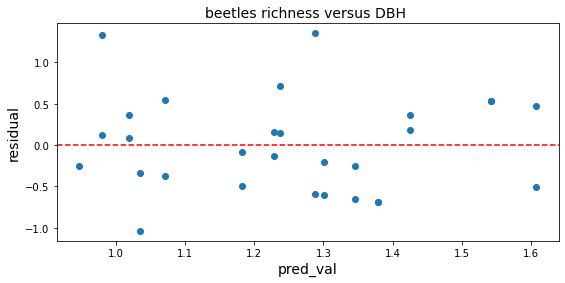

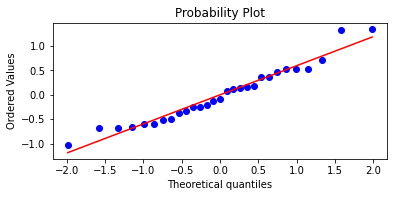

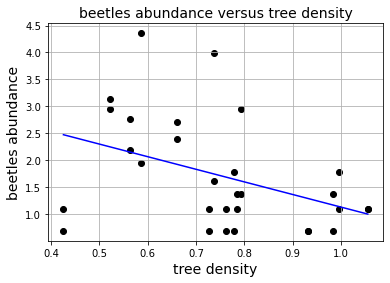

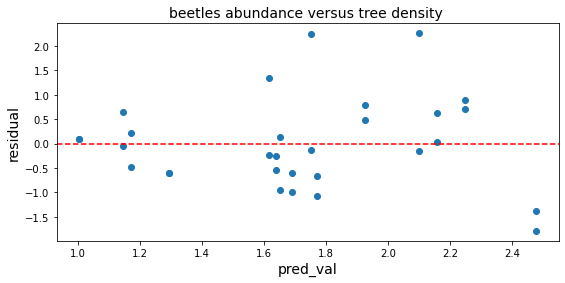

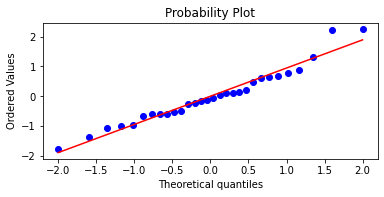

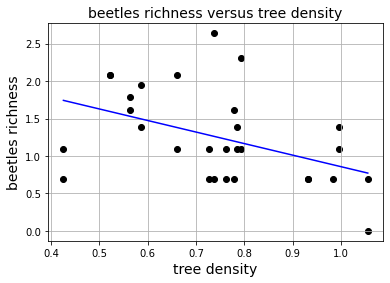

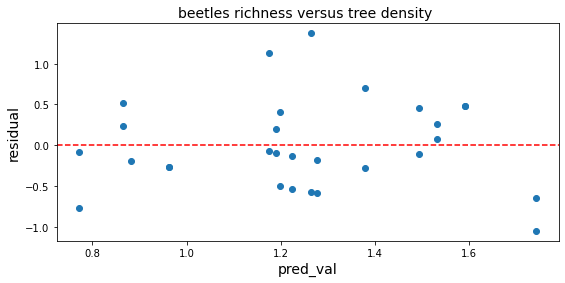

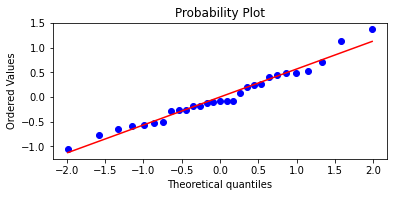

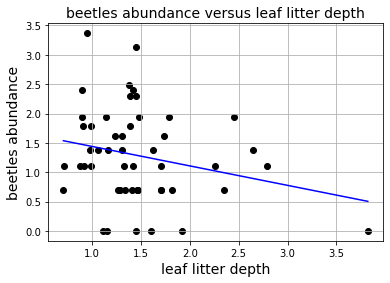

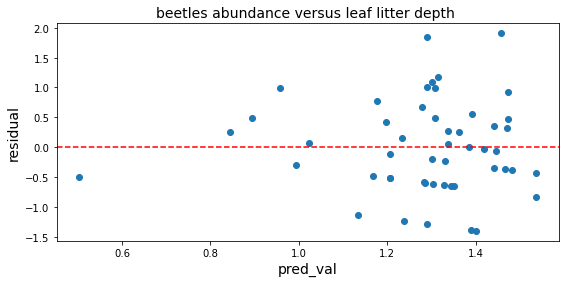

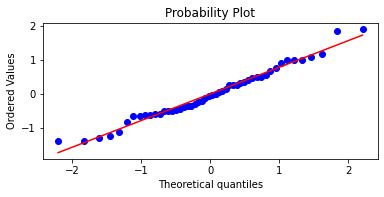

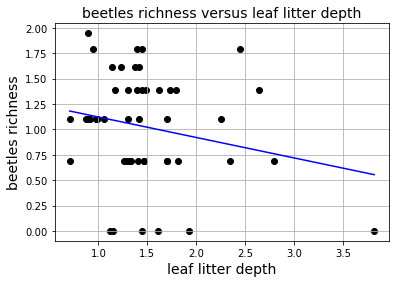

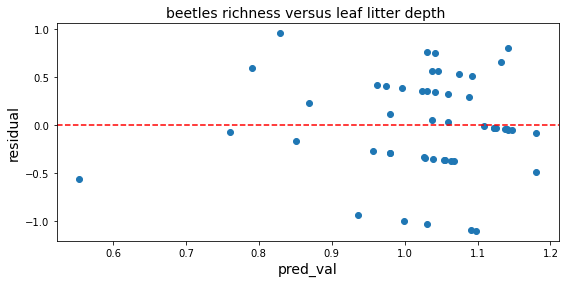

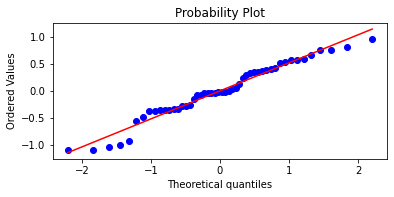

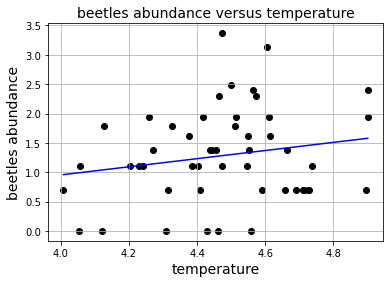

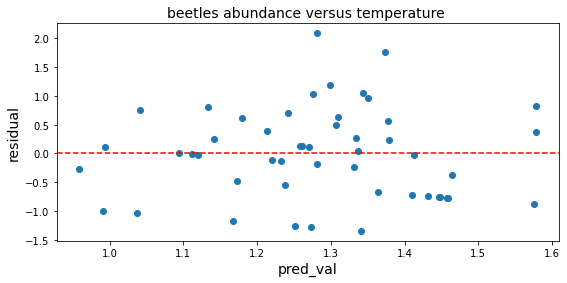

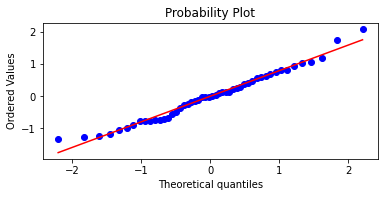

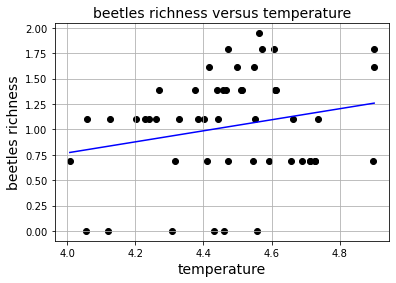

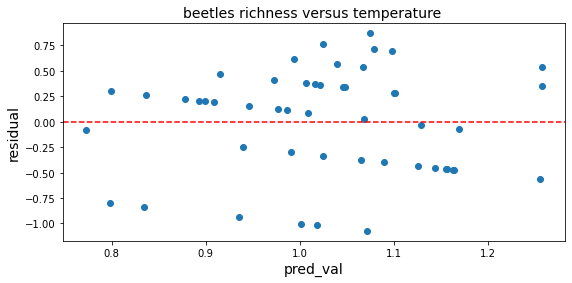

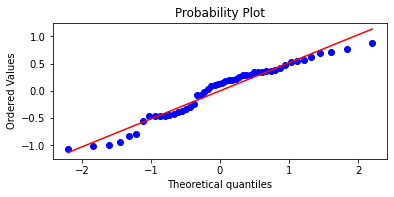

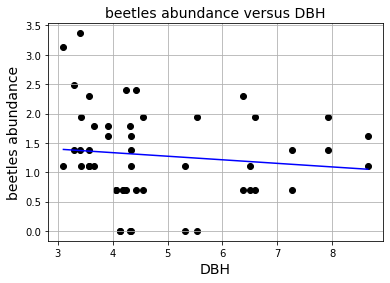

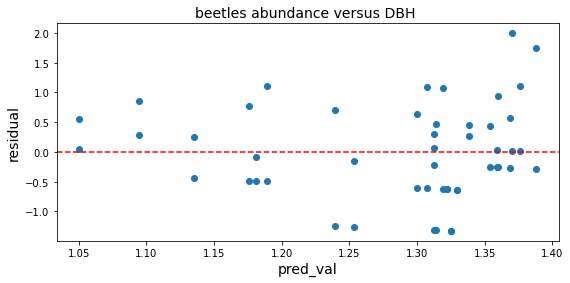

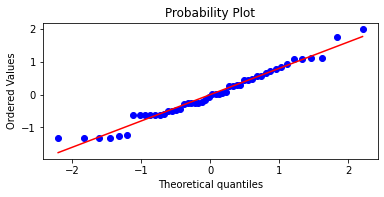

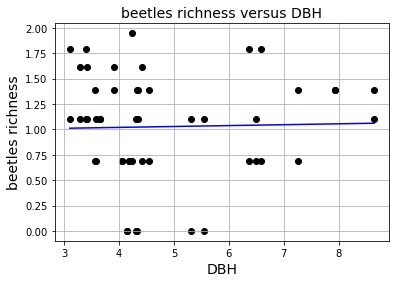

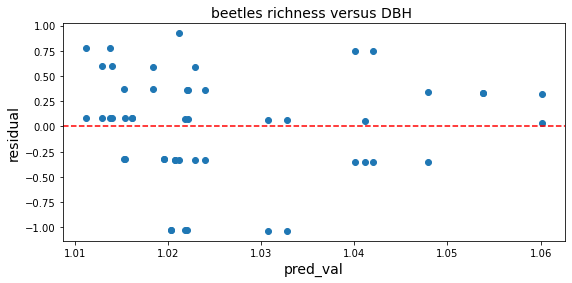

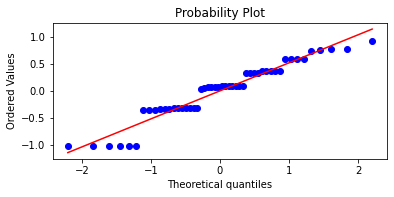

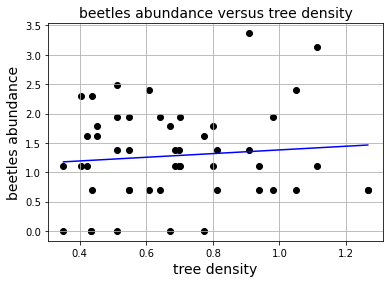

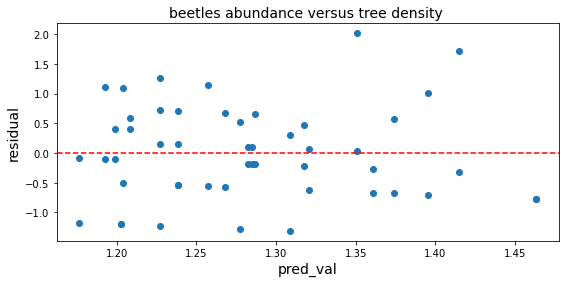

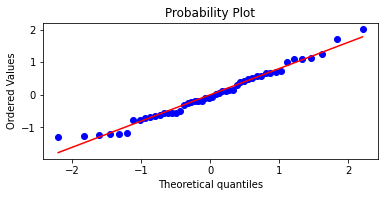

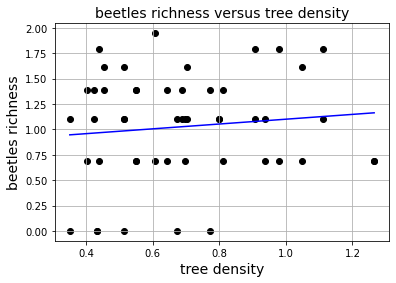

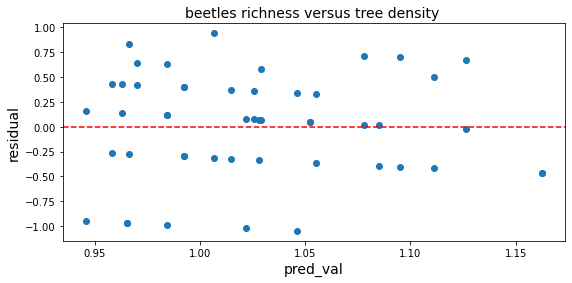

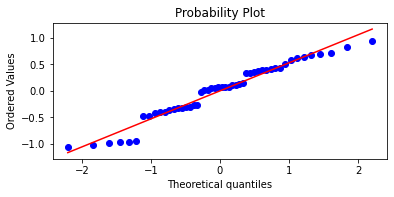

In [443]:
labels=[2018,2019,2021]
for i in range(len(all_dfs)):
    for var in ['leaf litter depth','temperature', 'DBH', 'tree density']:
        for y in ['beetles abundance', 'beetles richness']:
            df = all_dfs[i][~all_dfs[i][var].isna() & ~all_dfs[i][y].isna()]
            print(f'{labels[i]}: {y} versus {var}')
            X = np.array(df[var]).reshape(-1, 1)
            Y = df[y]
            # with sklearn
            regr = linear_model.LinearRegression()
            regr.fit(X, Y)

            print('Intercept: \n', regr.intercept_)
            print('Coefficients: \n', regr.coef_)

            x = np.linspace(df[var].min(),df[var].max(),100)
            y_grad = regr.intercept_+regr.coef_[0]*x
            plt.figure()
            plt.scatter(df[var],df[y], c='black')
            plt.plot(x,y_grad,'b-',label='Gradient Descent')
            plt.xlabel(var, fontsize=14)
            plt.ylabel(y, fontsize=14)
            plt.title(f'{y} versus {var}', fontsize=14)
            plt.grid(True)
            plt.show

            # with statsmodels
            X = sm.add_constant(X) # adding a constant

            model = sm.OLS(Y, X).fit()
            predictions = model.predict(X) 

            print_model = model.summary()
            print(print_model)

            pred_val = model.fittedvalues.copy()
            true_val = df[y].values.copy()
            residual = true_val - pred_val
            fig, ax = plt.subplots(figsize=(9,4))
            plt.axhline(y=0, color='r', linestyle='dashed')
            plt.title(f'{y} versus {var} ', fontsize=14)
            plt.xlabel("pred_val", fontsize=14)
            plt.ylabel("residual", fontsize=14)
            _ = ax.scatter(pred_val,residual)

            fig, ax = plt.subplots(figsize=(6,2.5))
            _, (__, ___, r) = stats.probplot(residual, plot=ax, fit=True)

In [444]:
D0 = df[df['distance'] == 0]
D1 = df[df['distance'] == 10]
D3 = df[df['distance'] == 30]
D5 = df[df['distance'] == 50]
D8 = df[df['distance'] == 80]

In [445]:
labels=[2018,2019,2021]
for i in range(len(all_dfs)):
    df=all_dfs[i][~all_dfs[i].isnull().any(axis=1)]
    X = df[['leaf litter depth','temperature', 'DBH', 'tree density']]
    Y1 = df['beetles abundance']
    # with sklearn
    regr = linear_model.LinearRegression()
    regr.fit(X, Y1)

    print('Intercept: \n', regr.intercept_)
    print('Coefficients: \n', regr.coef_)

Intercept: 
 -9.885247322554351
Coefficients: 
 [-0.79178347  2.94476355  0.04159717 -2.8735361 ]
Intercept: 
 9.136085442263644
Coefficients: 
 [ 0.64802252 -1.80262095  0.10124299 -1.55046998]
Intercept: 
 -2.6099757549105544
Coefficients: 
 [-0.43126739  1.02540238 -0.00117089 -0.08052206]


In [446]:
labels=[2018,2019,2021]
linestyles = ['-', '--', '-.', ':']
markers = ["o","D","<","p",">","v","*","^"]
colours = ['black','red','b']

2019: beetles abundance versus temperature
Intercept: 
 10.937598210808833
Coefficients: 
 [-1.95681166]

2019: beetles abundance versus tree density
Intercept: 
 3.471126262482737
Coefficients: 
 [-2.33665141]
 
 2019: beetles richness versus tree density
Intercept: 
 2.3990548169554553
Coefficients: 
 [-1.54153702]

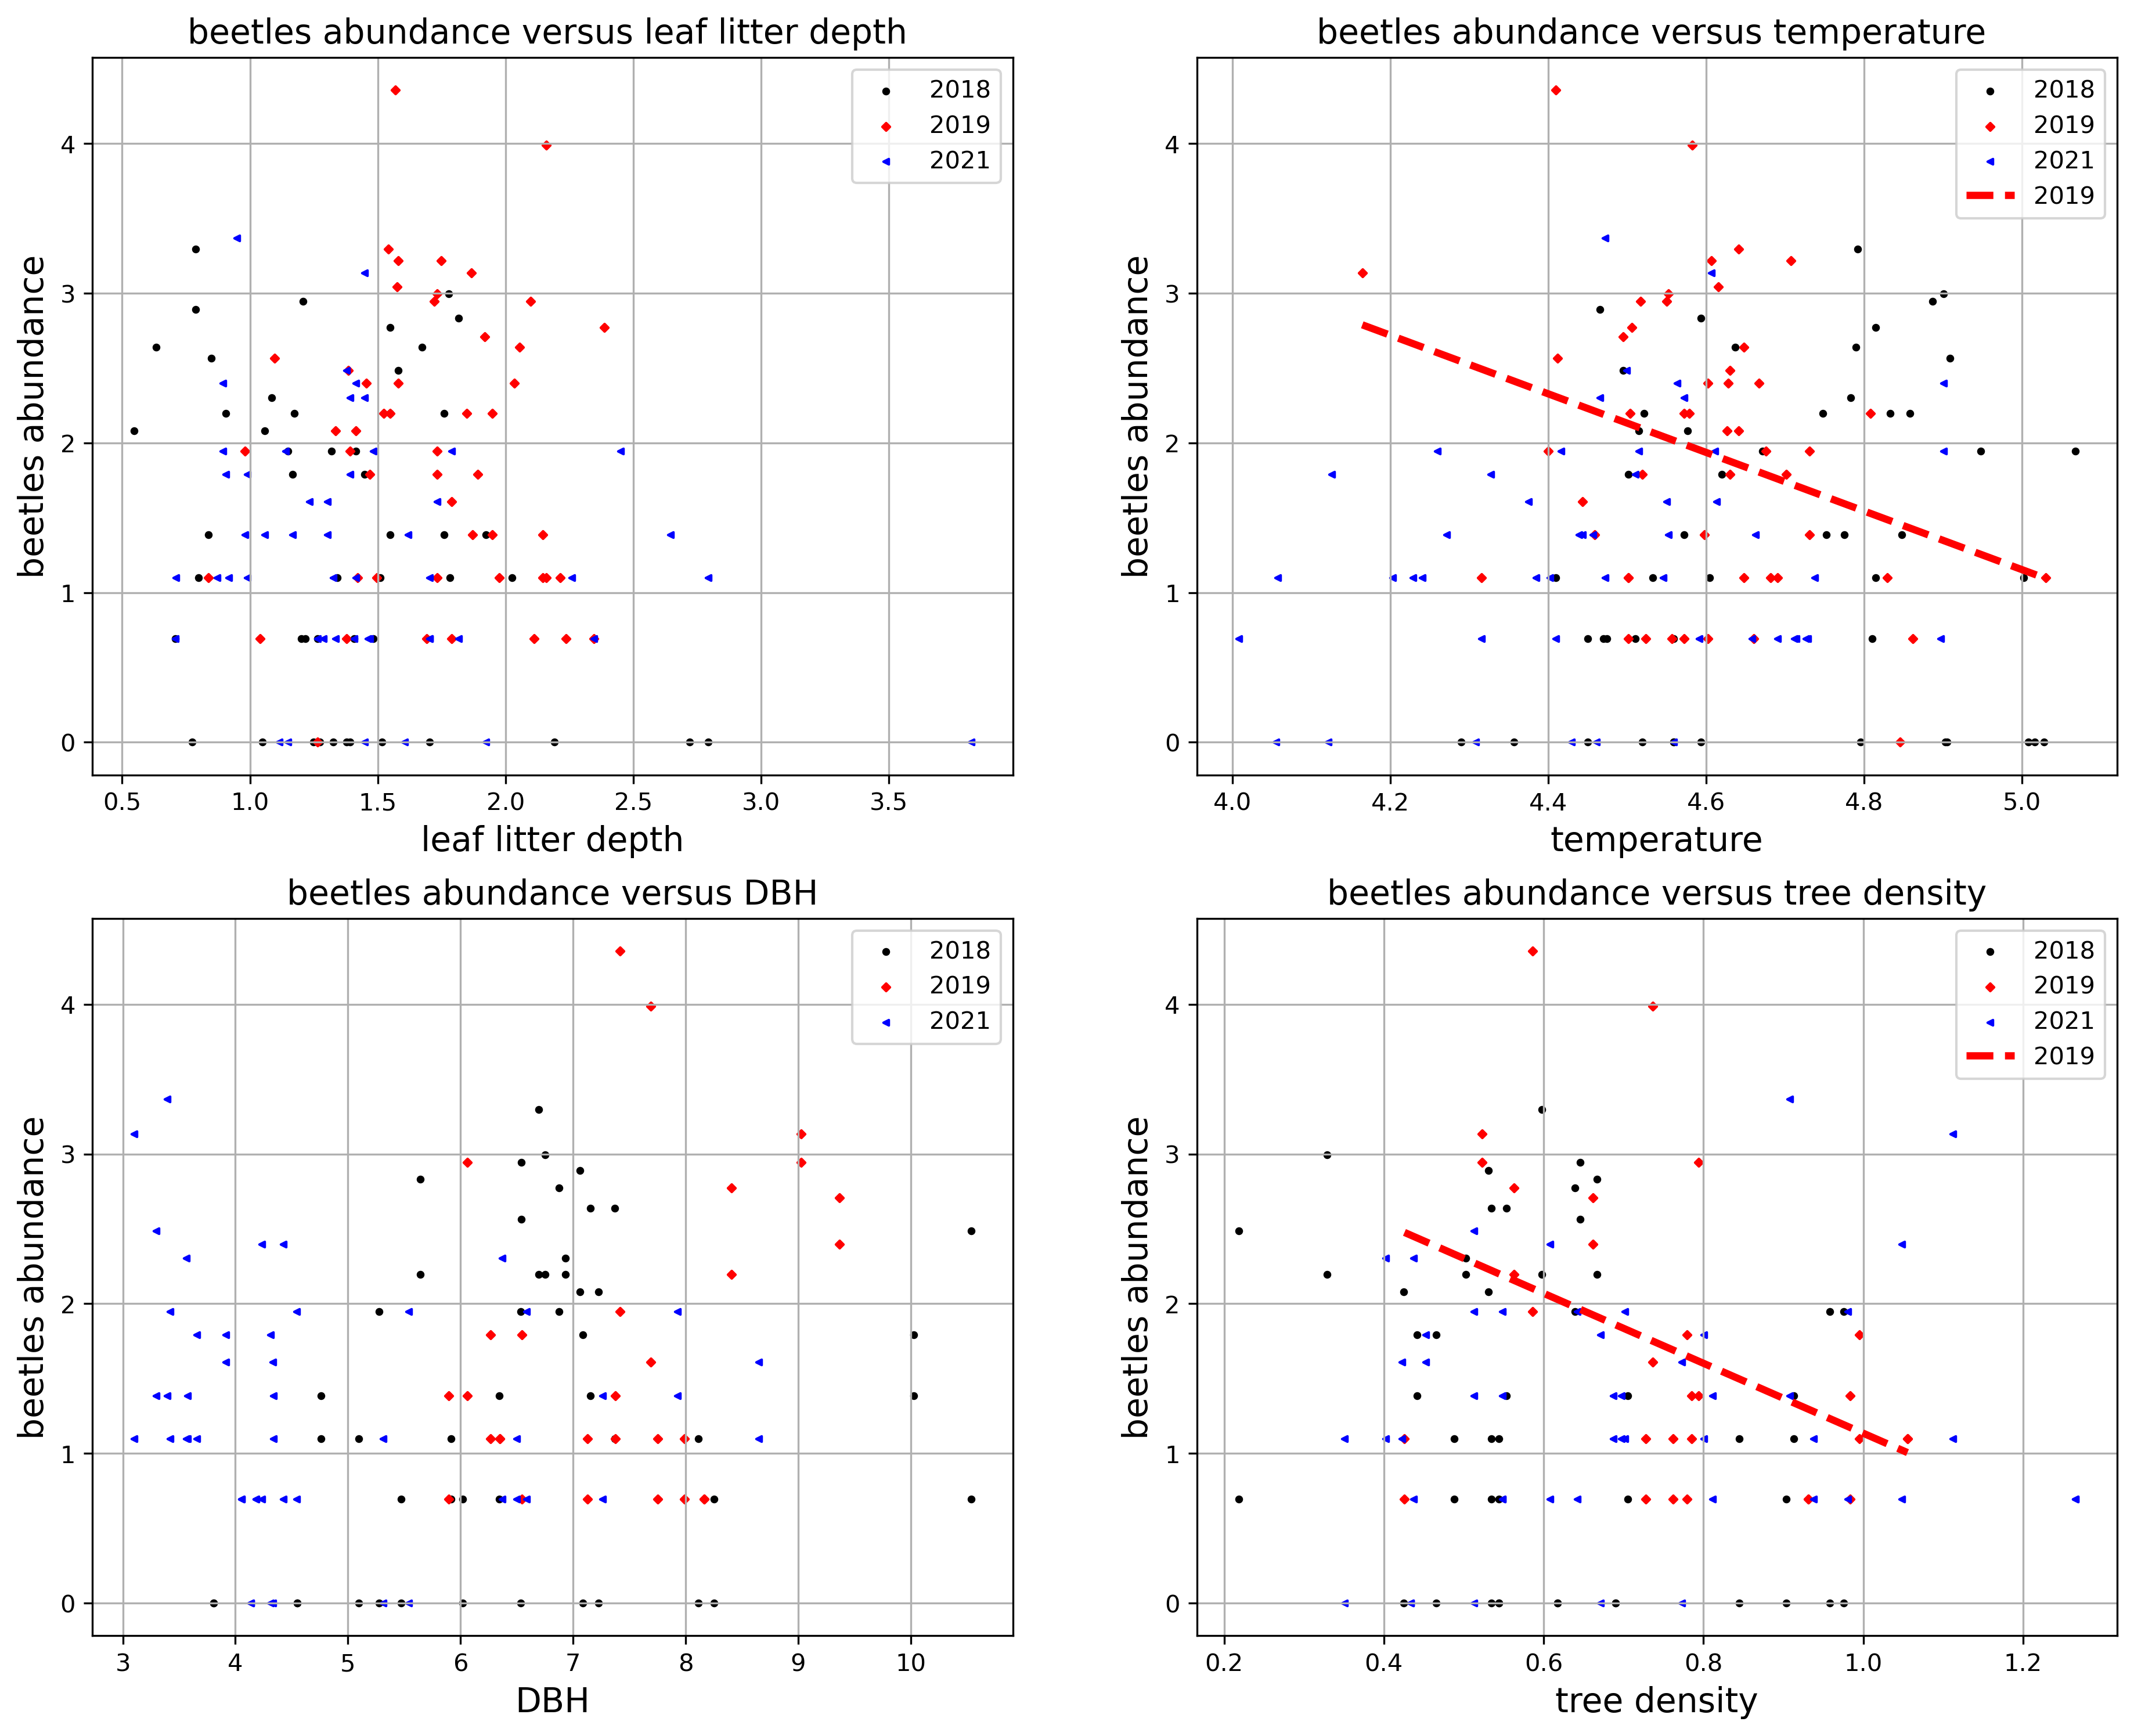

In [466]:
f = plt.figure(figsize=(15, 12), dpi = 300) 
sp =  f.add_subplot(2,2,1)
for i in range(len(all_dfs)):
#     x = np.linspace(all_dfs[i]['leaf litter depth'].min(),all_dfs[i]['leaf litter depth'].max(),100)
    plt.scatter(all_dfs[i]['leaf litter depth'],all_dfs[i]['beetles abundance'] ,s=5,c=colours[i],marker=markers[i], label=labels[i])
#     y_grad = regr.intercept_+regr.coef_[0]*x
#     plt.plot(x,y_grad,'b-',label='Gradient Descent',color='blue')
plt.xlabel('leaf litter depth', fontsize=14)
plt.ylabel('beetles abundance', fontsize=14)
plt.title('beetles abundance versus leaf litter depth ', fontsize=14)
plt.legend()
plt.grid(True)

sp =  f.add_subplot(2,2,2)
for i in range(len(all_dfs)):
    plt.scatter(all_dfs[i]['temperature'],all_dfs[i]['beetles abundance'],s=5,c=colours[i],marker=markers[i], label=labels[i])
x = np.linspace(all_dfs[1]['temperature'].min(),all_dfs[1]['temperature'].max(),100)
y_grad = 10.937598210808833-1.95681166*x
plt.plot(x,y_grad,label=labels[1],ls=linestyles[1],c=colours[1],lw=3)
plt.xlabel('temperature', fontsize=14)
plt.ylabel('beetles abundance', fontsize=14)
plt.title('beetles abundance versus temperature ', fontsize=14)
plt.legend()
plt.grid(True)

sp =  f.add_subplot(2,2,3)
for i in range(len(all_dfs)):
#     x = np.linspace(all_dfs[i]['DBH'].min(),all_dfs[i]['DBH'].max(),100)
#     y_grad = regr.intercept_+regr.coef_[1]*x
    plt.scatter(all_dfs[i]['DBH'],all_dfs[i]['beetles abundance'],s=5,c=colours[i],marker=markers[i], label=labels[i])
#     plt.plot(x,y_grad,'b-',label='Gradient Descent',color='blue')
plt.xlabel("DBH", fontsize=14)
plt.ylabel("beetles abundance", fontsize=14)
plt.title('beetles abundance versus DBH', fontsize=14)
plt.legend()
plt.grid(True)

sp =  f.add_subplot(2,2,4)
for i in range(len(all_dfs)):
    plt.scatter(all_dfs[i]['tree density'],all_dfs[i]['beetles abundance'],s=5,c=colours[i],marker=markers[i], label=labels[i])
x = np.linspace(all_dfs[1]['tree density'].min(),all_dfs[1]['tree density'].max(),100)
y_grad = 3.471126262482737-2.33665141*x
plt.plot(x,y_grad,label=labels[1],ls=linestyles[1],c=colours[1],lw=3)
plt.xlabel("tree density", fontsize=14)
plt.ylabel("beetles abundance", fontsize=14)
plt.title('beetles abundance versus tree density', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('/Users/johnngan/Desktop/BIOL3319/assignments/images/A_LTDD.pdf', bbox_inches='tight')
plt.show()

In [448]:
labels=[2018,2019,2021]
for i in range(len(all_dfs)):
    df=all_dfs[i][~all_dfs[i].isnull().any(axis=1)]
    X = df[['leaf litter depth','temperature', 'DBH', 'tree density']]
    Y1 = df['beetles richness']
    # with sklearn
    regr = linear_model.LinearRegression()
    regr.fit(X, Y1)

    print('Intercept: \n', regr.intercept_)
    print('Coefficients: \n', regr.coef_)

Intercept: 
 -5.482077433602617
Coefficients: 
 [-0.53968143  1.62969667  0.04959948 -1.20559376]
Intercept: 
 7.676073588732412
Coefficients: 
 [ 0.47592736 -1.43026382  0.00539007 -1.11283901]
Intercept: 
 -2.4501038538879656
Coefficients: 
 [-0.31878856  0.82527365  0.05520247 -0.02033721]


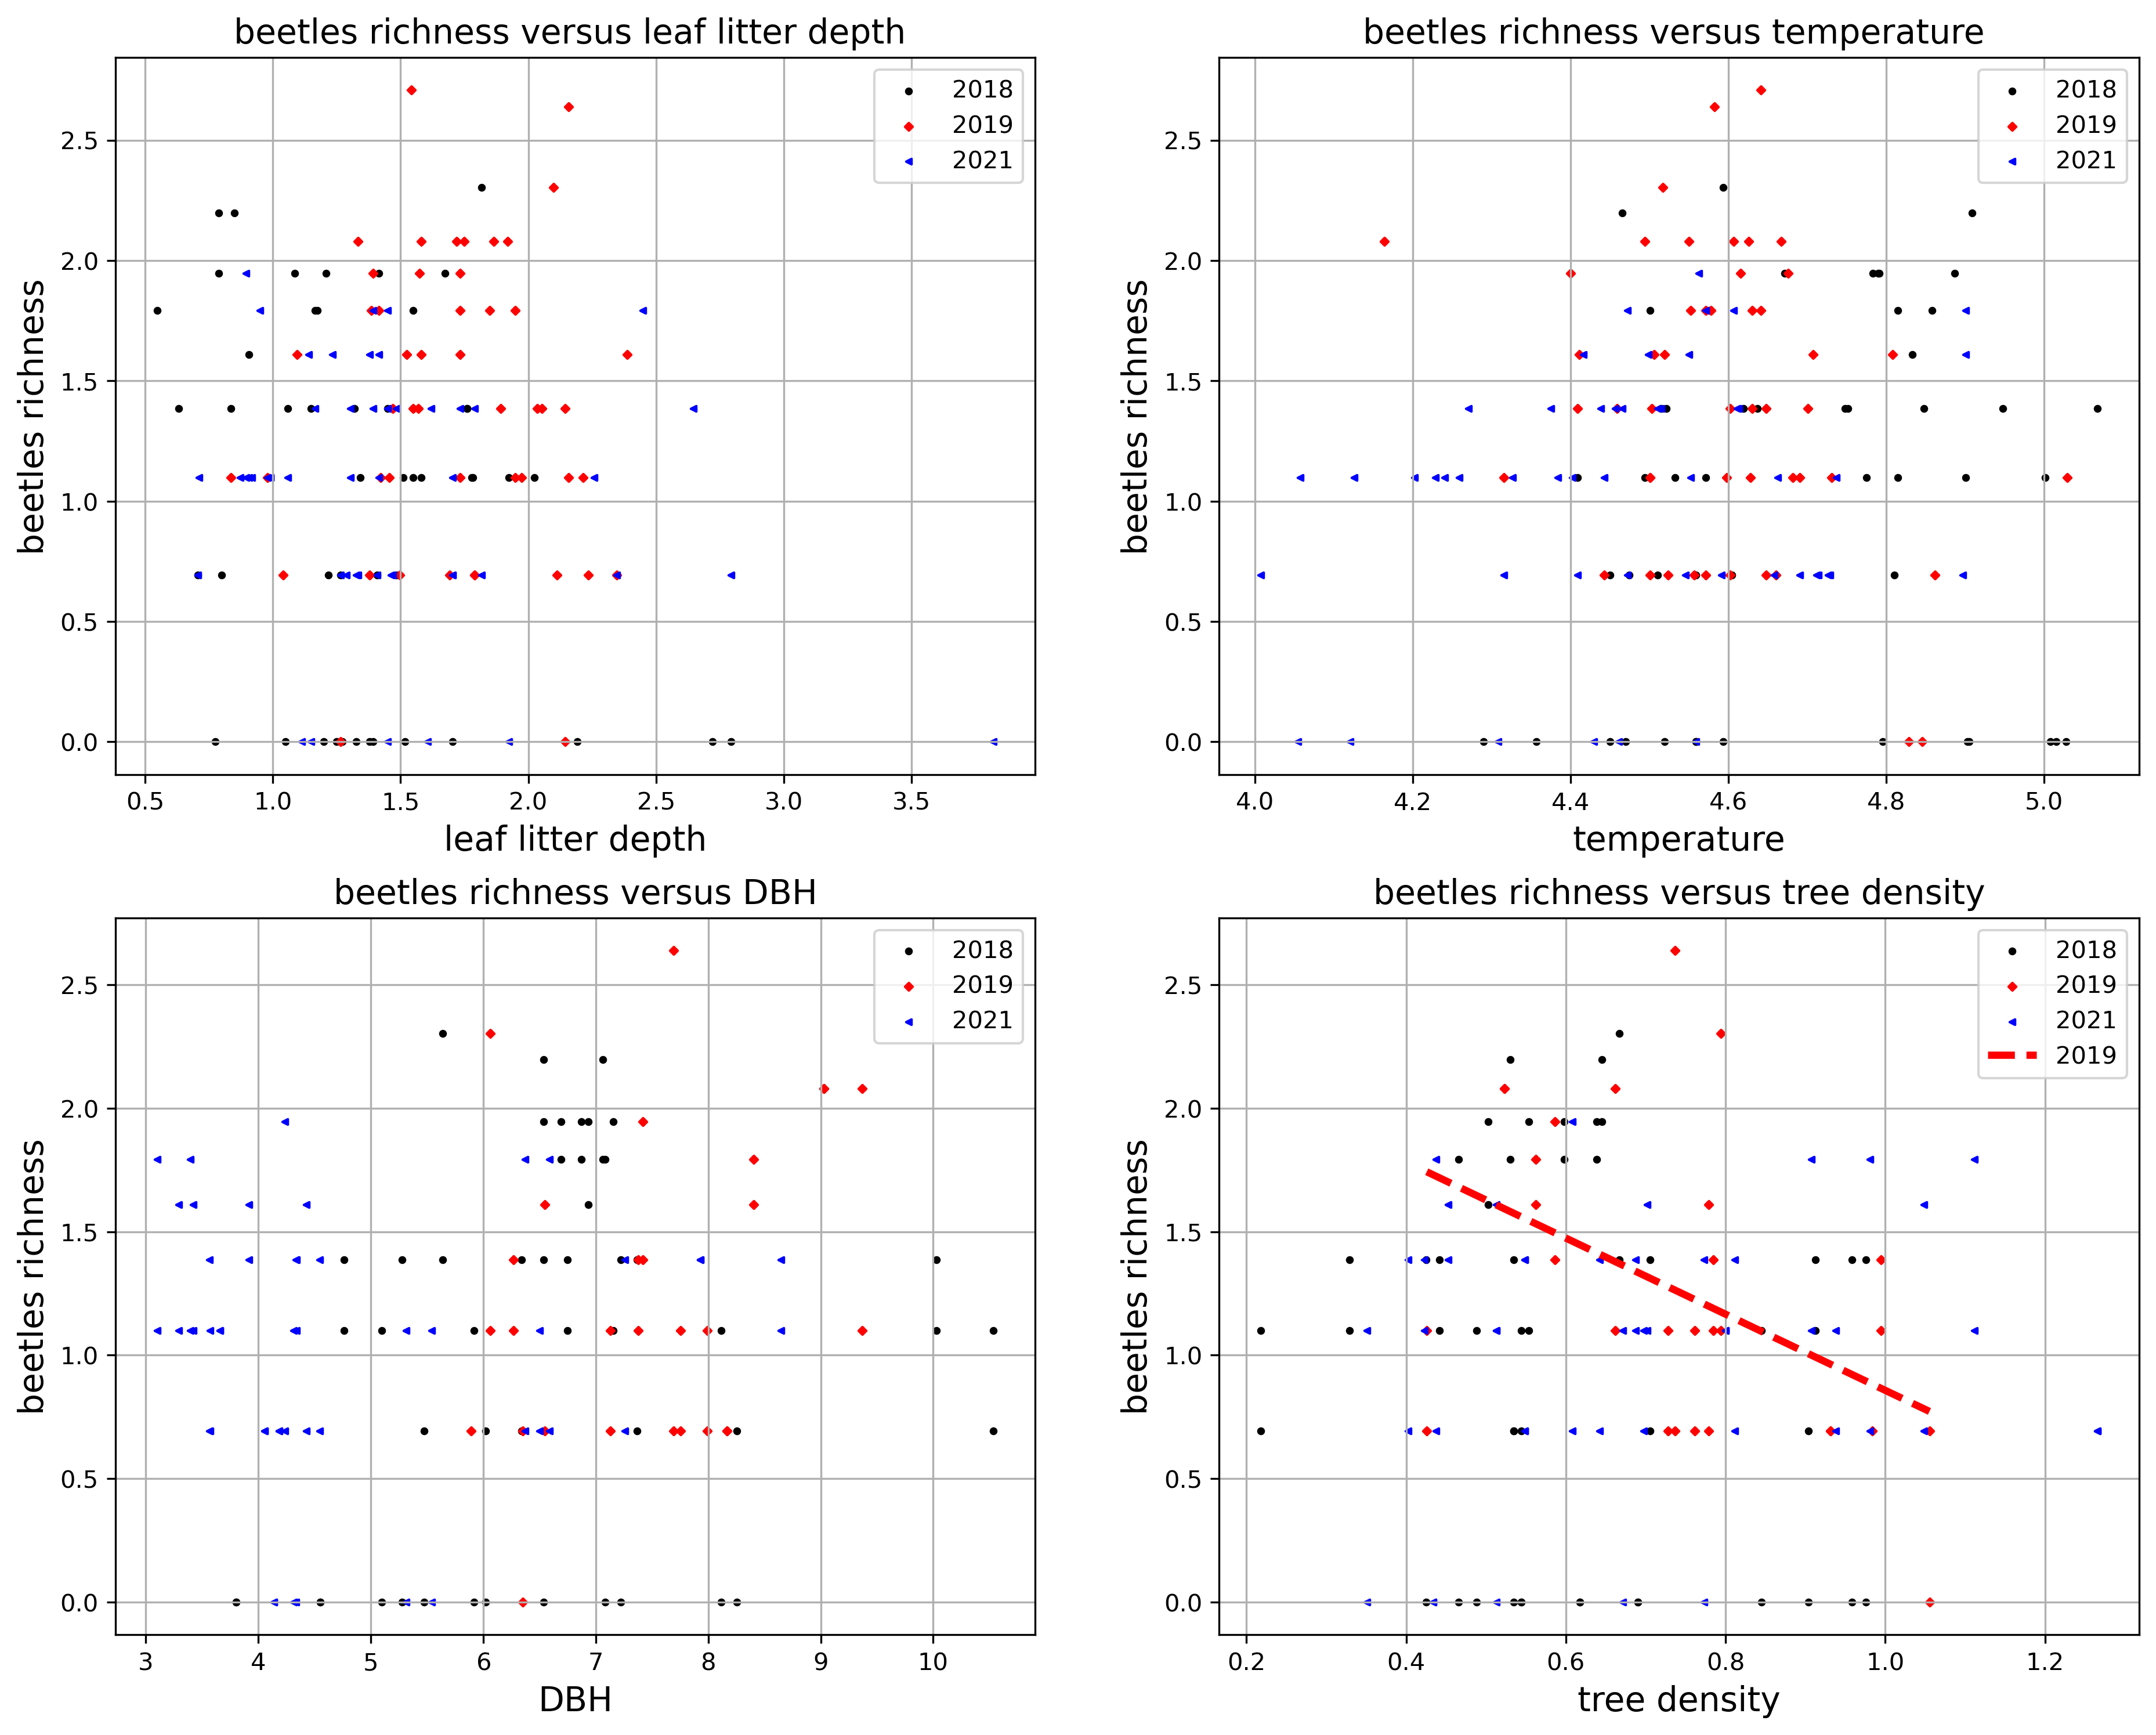

In [467]:
f = plt.figure(figsize=(15, 12), dpi = 300) 
sp =  f.add_subplot(2,2,1)
for i in range(len(all_dfs)):
#     x = np.linspace(all_dfs[i]['leaf litter depth'].min(),all_dfs[i]['leaf litter depth'].max(),100)
    plt.scatter(all_dfs[i]['leaf litter depth'],all_dfs[i]['beetles richness'] ,s=5,c=colours[i],marker=markers[i], label=labels[i])
#     y_grad = regr.intercept_+regr.coef_[0]*x
#     plt.plot(x,y_grad,'b-',label='Gradient Descent',color='blue')
plt.xlabel('leaf litter depth', fontsize=14)
plt.ylabel('beetles richness', fontsize=14)
plt.title('beetles richness versus leaf litter depth ', fontsize=14)
plt.legend()
plt.grid(True)

sp =  f.add_subplot(2,2,2)
for i in range(len(all_dfs)):
#     x = np.linspace(all_dfs[i]['temperature'].min(),all_dfs[i]['temperature'].max(),100)
#     y_grad = regr.intercept_+regr.coef_[0]*x
    plt.scatter(all_dfs[i]['temperature'],all_dfs[i]['beetles richness'],s=5,c=colours[i],marker=markers[i], label=labels[i])
#     plt.plot(x,y_grad,'b-',label='Gradient Descent',color='blue')
plt.xlabel('temperature', fontsize=14)
plt.ylabel('beetles richness', fontsize=14)
plt.title('beetles richness versus temperature ', fontsize=14)
plt.legend()
plt.grid(True)

sp =  f.add_subplot(2,2,3)
for i in range(len(all_dfs)):
#     x = np.linspace(all_dfs[i]['DBH'].min(),all_dfs[i]['DBH'].max(),100)
#     y_grad = regr.intercept_+regr.coef_[1]*x
    plt.scatter(all_dfs[i]['DBH'],all_dfs[i]['beetles richness'],s=5,c=colours[i],marker=markers[i], label=labels[i])
#     plt.plot(x,y_grad,'b-',label='Gradient Descent',color='blue')
plt.xlabel("DBH", fontsize=14)
plt.ylabel("beetles richness", fontsize=14)
plt.title('beetles richness versus DBH', fontsize=14)
plt.legend()
plt.grid(True)

sp =  f.add_subplot(2,2,4)
for i in range(len(all_dfs)):
    plt.scatter(all_dfs[i]['tree density'],all_dfs[i]['beetles richness'],s=5,c=colours[i],marker=markers[i], label=labels[i])
x = np.linspace(all_dfs[1]['tree density'].min(),all_dfs[1]['tree density'].max(),100)
y_grad = 2.3990548169554553-1.54153702*x
plt.plot(x,y_grad,label=labels[1],ls=linestyles[1],c=colours[1],lw=3)
plt.xlabel("tree density", fontsize=14)
plt.ylabel("beetles richness", fontsize=14)
plt.title('beetles richness versus tree density', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('/Users/johnngan/Desktop/BIOL3319/assignments/images/R_LTDD.pdf', bbox_inches='tight')
plt.show()

beetles abundance ->False 

beetles richness ->False

leaf litter depth ->True

temperature ->True

DBH ->True


tree density ->True

beetles abundance ->True

beetles richness ->True

leaf litter depth ->True

temperature ->True

DBH ->False



tree density ->False

beetles abundance ->True

beetles richness ->False

leaf litter depth ->True

temperature ->True

DBH ->True

tree density ->True


In [459]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
df= all_dfs[0]
# print(pearsonr(df['leaf litter depth'],df['beetles abundance']))
# print(pearsonr(df['temperature'],df['beetles abundance']))
# print(pearsonr(df['DBH'],df['beetles abundance']))
# print(pearsonr(df['tree density'],df['beetles abundance']))
# print(pearsonr(df['temperature'],df['beetles richness']))
# print(pearsonr(df['leaf litter depth'],df['beetles richness']))
# print(pearsonr(df['DBH'],df['beetles richness']))
# print(pearsonr(df['tree density'],df['beetles richness']))
print(spearmanr(df['leaf litter depth'],df['beetles abundance']))
print(spearmanr(df['temperature'],df['beetles abundance']))
print(spearmanr(df['DBH'],df['beetles abundance']))
print(spearmanr(df['tree density'],df['beetles abundance']))
print(spearmanr(df['temperature'],df['beetles richness']))
print(spearmanr(df['leaf litter depth'],df['beetles richness']))
print(spearmanr(df['DBH'],df['beetles richness']))
print(spearmanr(df['tree density'],df['beetles richness']))

SpearmanrResult(correlation=-0.15635145828288163, pvalue=0.2782344303318604)
SpearmanrResult(correlation=0.14959239533668334, pvalue=0.29979537859331146)
SpearmanrResult(correlation=0.26986038457217926, pvalue=0.058057173874379475)
SpearmanrResult(correlation=-0.20412522667603805, pvalue=0.15505616289955498)
SpearmanrResult(correlation=0.14959239533668334, pvalue=0.29979537859331146)
SpearmanrResult(correlation=-0.20971492086087865, pvalue=0.14382023322614426)
SpearmanrResult(correlation=0.2076587778210284, pvalue=0.14788079436241006)
SpearmanrResult(correlation=-0.07196976376498647, pvalue=0.6194172965880849)


In [462]:
df= all_dfs[1]
print(pearsonr(df['leaf litter depth'],df['beetles abundance']))
print(pearsonr(df['temperature'],df['beetles abundance']))
# print(pearsonr(df['DBH'][~df['DBH'].isna()],df['beetles abundance'][~df['DBH'].isna()]))
# print(pearsonr(df['tree density'][~df['tree density'].isna()],df['beetles abundance'][~df['tree density'].isna()]))
print(pearsonr(df['temperature'][~df['beetles richness'].isna()],df['beetles richness'][~df['beetles richness'].isna()]))
print(pearsonr(df['leaf litter depth'][~df['beetles richness'].isna()],df['beetles richness'][~df['beetles richness'].isna()]))
# print(pearsonr(df['DBH'][~df['DBH'].isna()][~df['beetles richness'].isna()],df['beetles richness'][~df['DBH'].isna()][~df['beetles richness'].isna()]))
# print(pearsonr(df['tree density'][~df['tree density'].isna()][~df['beetles richness'].isna()],df['beetles richness'][~df['tree density'].isna()][~df['beetles richness'].isna()]))
# print(spearmanr(df['leaf litter depth'],df['beetles abundance']))
# print(spearmanr(df['temperature'],df['beetles abundance']))
print(spearmanr(df['DBH'][~df['DBH'].isna()],df['beetles abundance'][~df['DBH'].isna()]))
print(spearmanr(df['tree density'][~df['tree density'].isna()],df['beetles abundance'][~df['tree density'].isna()]))
# print(spearmanr(df['temperature'][~df['beetles richness'].isna()],df['beetles richness'][~df['beetles richness'].isna()]))
# print(spearmanr(df['leaf litter depth'][~df['beetles richness'].isna()],df['beetles richness'][~df['beetles richness'].isna()]))
print(spearmanr(df['DBH'][~df['DBH'].isna()][~df['beetles richness'].isna()],df['beetles richness'][~df['DBH'].isna()][~df['beetles richness'].isna()]))
print(spearmanr(df['tree density'][~df['tree density'].isna()][~df['beetles richness'].isna()],df['beetles richness'][~df['tree density'].isna()][~df['beetles richness'].isna()]))

(0.019733695211243726, 0.8918037768484394)
(-0.2923503724261124, 0.0393802161226624)
(-0.2778069153218187, 0.05327577115050701)
(0.010965326357526936, 0.9403913707153931)
SpearmanrResult(correlation=0.25473101104086315, pvalue=0.17431520482226903)
SpearmanrResult(correlation=-0.374870104900561, pvalue=0.04123946273163761)
SpearmanrResult(correlation=0.2502792597790717, pvalue=0.19037679625016637)
SpearmanrResult(correlation=-0.41393310472038203, pvalue=0.025598639197171397)


In [463]:
df= all_dfs[2]
print(pearsonr(df['leaf litter depth'],df['beetles abundance']))
print(pearsonr(df['temperature'],df['beetles abundance']))
print(pearsonr(df['DBH'],df['beetles abundance']))
print(pearsonr(df['tree density'],df['beetles abundance']))
# print(pearsonr(df['temperature'],df['beetles richness']))
# print(pearsonr(df['leaf litter depth'],df['beetles richness']))
# print(pearsonr(df['DBH'],df['beetles richness']))
# print(pearsonr(df['tree density'],df['beetles richness']))
# print(spearmanr(df['leaf litter depth'],df['beetles abundance']))
# print(spearmanr(df['temperature'],df['beetles abundance']))
# print(spearmanr(df['DBH'],df['beetles abundance']))
# print(spearmanr(df['tree density'],df['beetles abundance']))
print(spearmanr(df['temperature'],df['beetles richness']))
print(spearmanr(df['leaf litter depth'],df['beetles richness']))
print(spearmanr(df['DBH'],df['beetles richness']))
print(spearmanr(df['tree density'],df['beetles richness']))

(-0.24016018013421375, 0.09297238895616501)
(0.18767211890336877, 0.19185571425490092)
(-0.11600626241779657, 0.42240568288275504)
(0.0950227607427163, 0.5115632072131495)
SpearmanrResult(correlation=0.15915046376579425, pvalue=0.2696129076965503)
SpearmanrResult(correlation=-0.1479917091330303, pvalue=0.3050552873375089)
SpearmanrResult(correlation=-0.0833158659511282, pvalue=0.5651337859967205)
SpearmanrResult(correlation=0.07645308094602508, pvalue=0.5977041847050695)
